In [1]:
import json
import pandas as pd
with open('/data/en.train_copy.jsonl') as json_file:
  json_data = json.load(json_file)
  df = pd.DataFrame.from_records(json_data)
df = df.drop(['gender','id','age_exact'], axis=1)
df.head()
###

,age,text
0,40s,Not the best overall service.
1,40s,Since it is the #1 social network however with...
2,40s,"Not only that you can find anything, but its r..."
3,40s,I'm always satisfied with their level of servi...
4,30s,"On time, nice chap and worked like a pro - Ver..."


# length of the Data

In [2]:
print(len(df))

4996


In [3]:
# !pip install shap transformers torch wordcloud spacy

In [8]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.1/453.1 kB 162.8 kB/s eta 0:00:00 kB/s eta 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [9]:

import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import shap
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import spacy
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

nlp = spacy.load("en_core_web_sm")

plt.figure()

2024-07-15 09:49:46.076683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pemagurung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pemagurung/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pemagurung/nltk_data...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Age label distribution

In [10]:
df.age.value_counts()

age
20s     1176
60s      985
30s      854
50s      707
40s      695
70s      259
10s      190
100s      67
80s       41
90s       15
110s       7
Name: count, dtype: int64

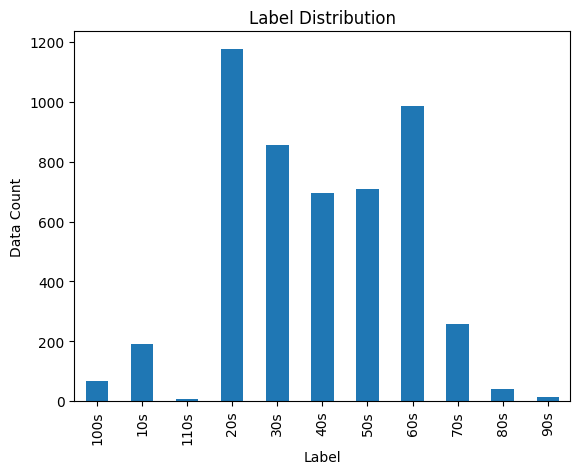

In [11]:
df.age.value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel("Label")
plt.ylabel("Data Count")
plt.title('Label Distribution')
plt.show()

**Note:** Since above the age of 70s are really old people, we can merge 80s-110s to 70s

In [12]:
df['age'] = df['age'].str.replace('80s','70s').str.replace('90s','70s').str.replace('100s','70s').str.replace('110s','70s')
df.head()

,age,text
0,40s,Not the best overall service.
1,40s,Since it is the #1 social network however with...
2,40s,"Not only that you can find anything, but its r..."
3,40s,I'm always satisfied with their level of servi...
4,30s,"On time, nice chap and worked like a pro - Ver..."


In [13]:
df.age.value_counts()

age
20s    1176
60s     985
30s     854
50s     707
40s     695
70s     389
10s     190
Name: count, dtype: int64

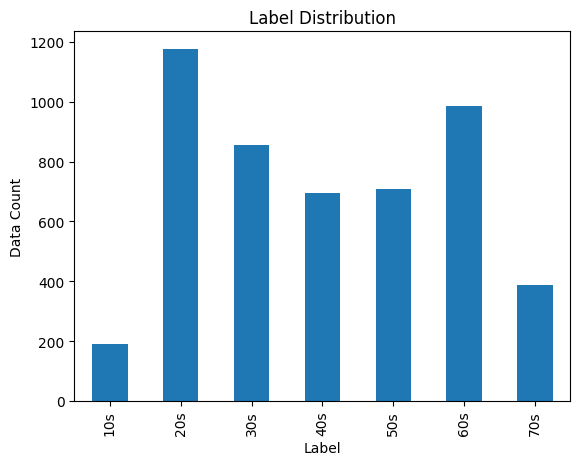

In [14]:
df.age.value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel("Label")
plt.ylabel("Data Count")
plt.title('Label Distribution')
plt.show()

# Sentence Length based on Age

In [15]:
def sent_len(text):
  doc = nlp(text)
  sents_list = [sent.text for sent in doc.sents]
  return len(sents_list)


In [16]:
df["text_sent_len"] = df["text"].apply(sent_len)
df.head(2)

,age,text,text_sent_len
0,40s,Not the best overall service.,1
1,40s,Since it is the #1 social network however with...,1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.008785063736219637


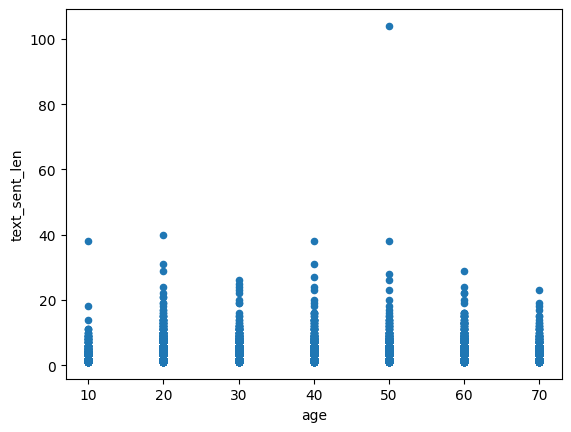

In [17]:
new_df = df[['age', 'text_sent_len']]
new_df['age'] = new_df['age'].str.replace('s','')
new_df["age"] = pd.to_numeric(new_df["age"])

print(new_df['age'].corr(new_df['text_sent_len']))
new_df.plot.scatter(x='age', y='text_sent_len')
plt.show()

In [18]:
df.head()

,age,text,text_sent_len
0,40s,Not the best overall service.,1
1,40s,Since it is the #1 social network however with...,1
2,40s,"Not only that you can find anything, but its r...",1
3,40s,I'm always satisfied with their level of servi...,2
4,30s,"On time, nice chap and worked like a pro - Ver...",1


In [19]:
df[df["text_sent_len"]>=100]

,age,text,text_sent_len
4051,50s,BUYER BEWARE !!! How Nissan Of Chesapeake GOT ...,104


# Word Count

In [20]:
def word_len(text):
  doc = nlp(text)
  words_list = [token.text for token in doc]
  return len(words_list)


In [21]:
df["text_word_len"] = df["text"].apply(word_len)
df.head(2)

,age,text,text_sent_len,text_word_len
0,40s,Not the best overall service.,1,6
1,40s,Since it is the #1 social network however with...,1,53


In [22]:
new_df1 = df[['age', 'text_word_len']]
new_df1.head()

,age,text_word_len
0,40s,6
1,40s,53
2,40s,16
3,40s,42
4,30s,17



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-0.005588867579238317


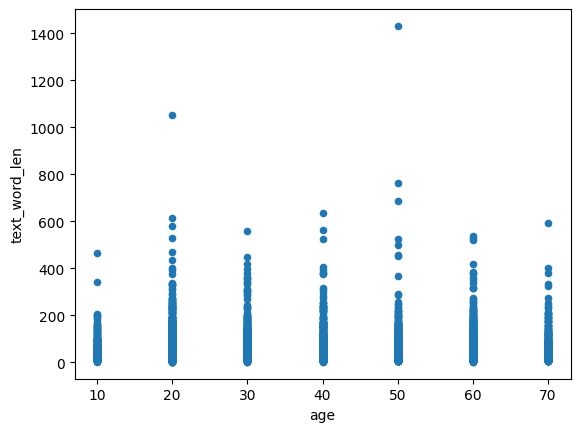

In [23]:
new_df1["age"] = new_df1["age"].str.replace('s','')
new_df1["age"] = pd.to_numeric(new_df1["age"])

print(new_df1['age'].corr(new_df1['text_word_len']))
new_df1.plot.scatter(x='age', y='text_word_len')
plt.show()

In [24]:
df[df["text_word_len"]>=1000]

,age,text,text_sent_len,text_word_len
2460,20s,I'm editing my review to reflect what my exper...,40,1052
4051,50s,BUYER BEWARE !!! How Nissan Of Chesapeake GOT ...,104,1432


# Sentiment Analysis

 Determining the sentiment of the text data and analyzing its distribution across different age groups.

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pemagurung/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
sentiment_model = SentimentIntensityAnalyzer()

def return_sentiment(text):
  if sentiment_model.polarity_scores(text)["compound"] >= 0: #sentiment as positive when compound value is positive and sentiment as negative when the compound value is negative
    return "positive"
  else:
    return "negative"



In [27]:
df["text_sentiment"] = df["text"].apply(return_sentiment)


In [28]:
df.head()

,age,text,text_sent_len,text_word_len,text_sentiment
0,40s,Not the best overall service.,1,6,negative
1,40s,Since it is the #1 social network however with...,1,53,positive
2,40s,"Not only that you can find anything, but its r...",1,16,positive
3,40s,I'm always satisfied with their level of servi...,2,42,positive
4,30s,"On time, nice chap and worked like a pro - Ver...",1,17,positive


In [29]:
# ToDo: For each age group, get the pos n neg sentiment
age_groups = df["age"].unique()

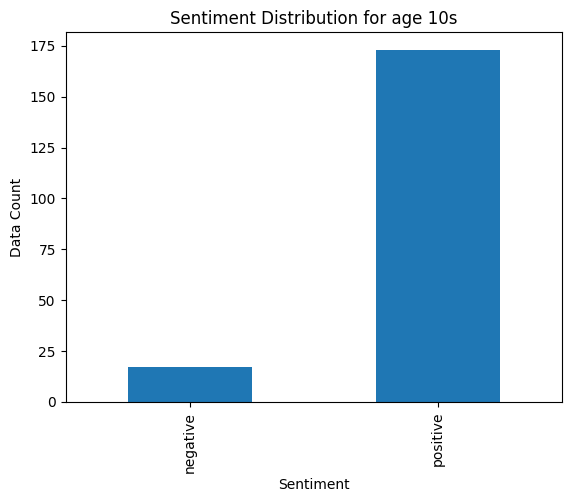

In [30]:
age_df = df[df["age"]=="10s"]
age_df = age_df[["age","text_sentiment"]]
age_df.text_sentiment.value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel("Sentiment")
plt.ylabel("Data Count")
plt.title('Sentiment Distribution for age 10s')
plt.show()

# Note: It is noticed that most of the reviews were positive among all age group

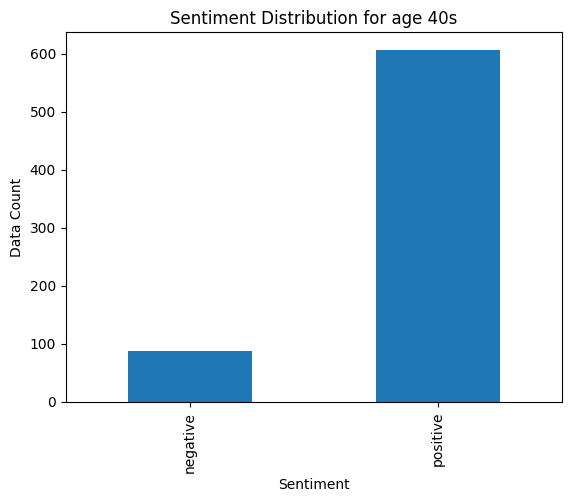

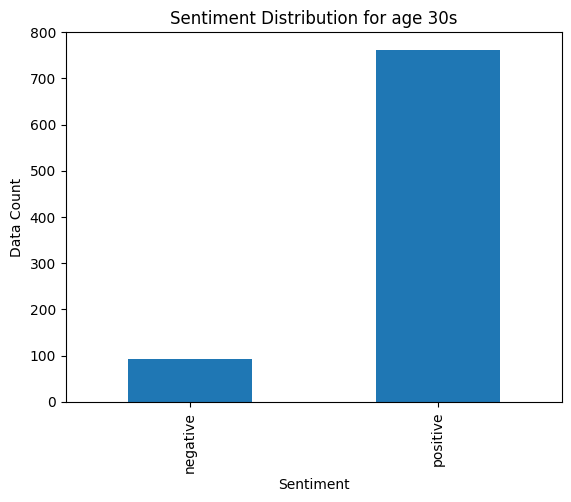

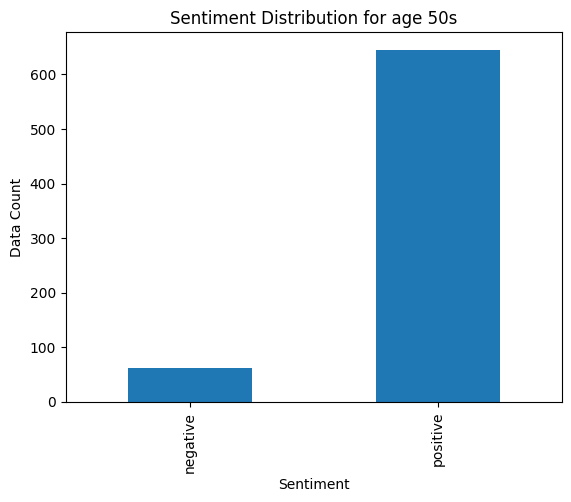

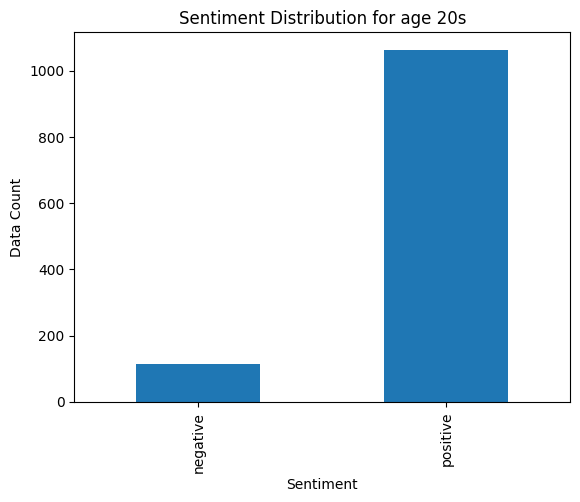

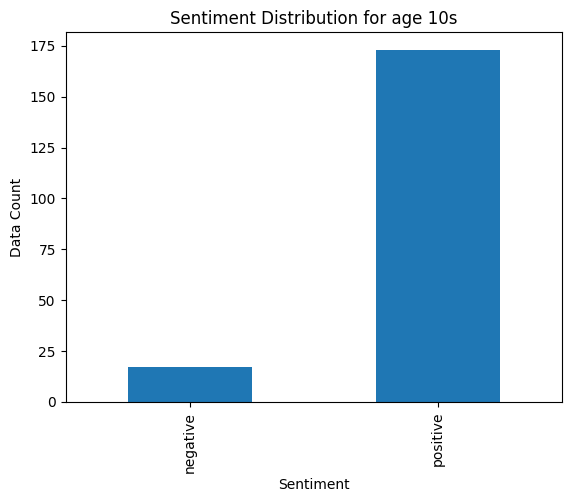

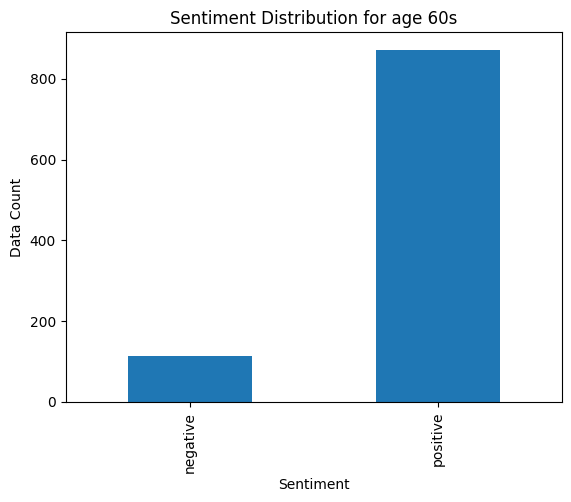

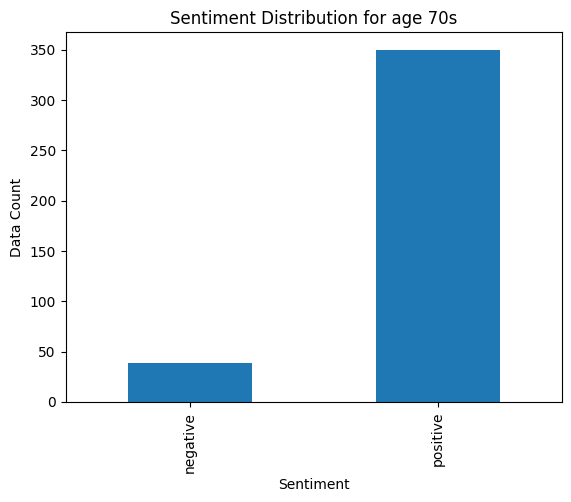

In [31]:
# Observing how sentiment in text varies across different age groups.

sentiment_model = SentimentIntensityAnalyzer()

def return_sentiment(text):
    return "positive" if sentiment_model.polarity_scores(text)["compound"] >= 0 else "negative"

df["text_sentiment"] = df["text"].apply(return_sentiment)

age_groups = df["age"].unique()

for age in age_groups:
    age_df = df[df["age"] == age]
    age_df["text_sentiment"].value_counts().sort_index(ascending=True).plot(kind='bar')
    plt.xlabel("Sentiment")
    plt.ylabel("Data Count")
    plt.title(f'Sentiment Distribution for age {age}')
    plt.show()

# Word Frequency Analysis:
Identifying the most frequent words or phrases in the text data.


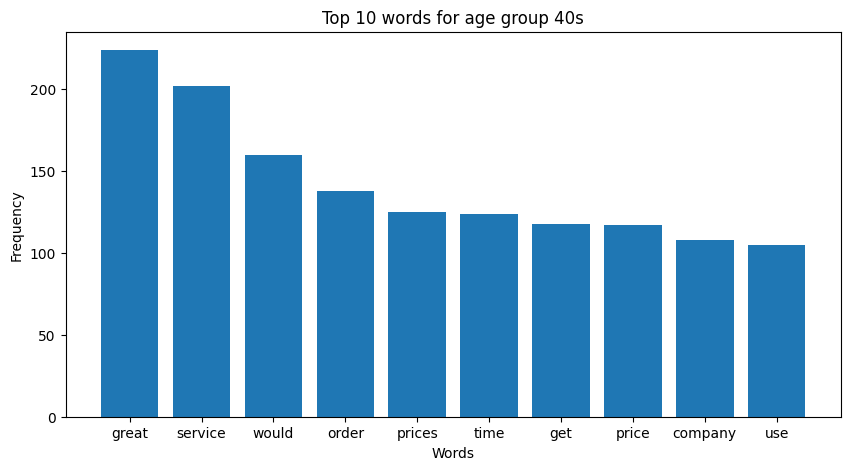

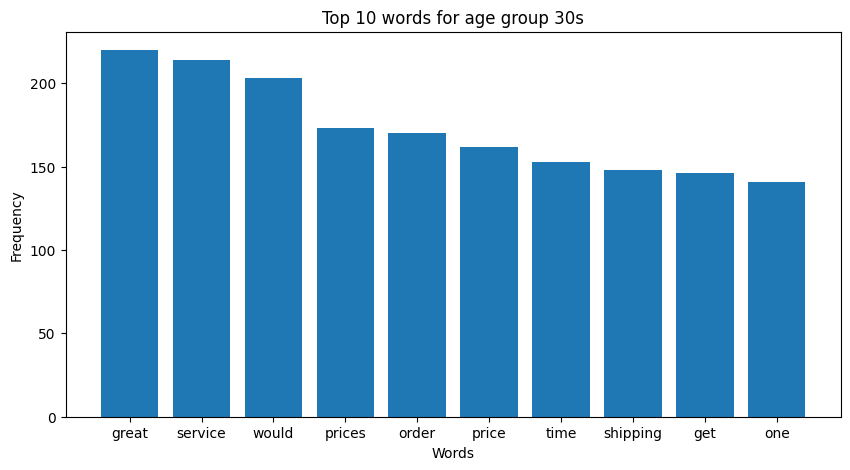

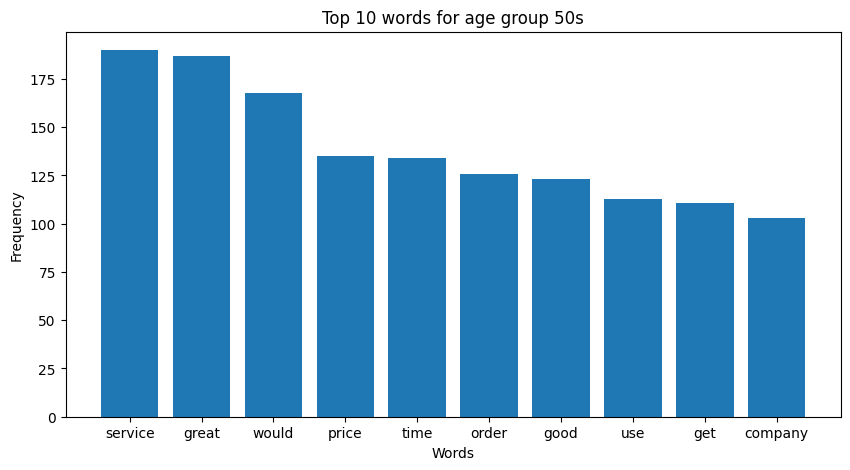

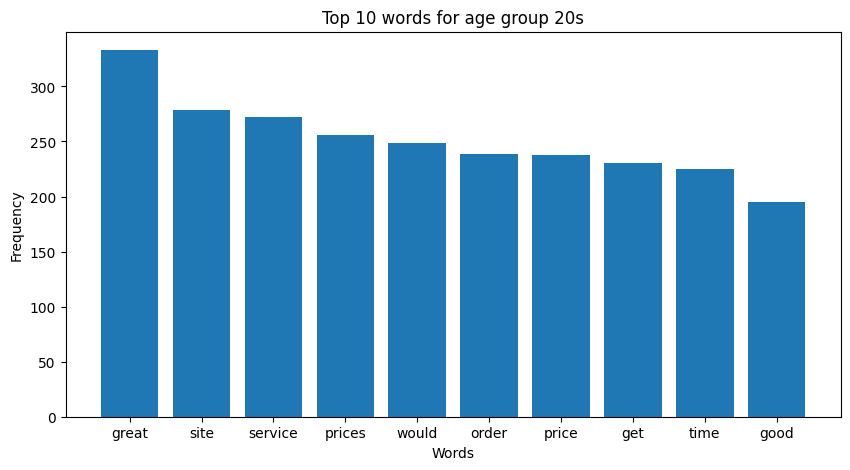

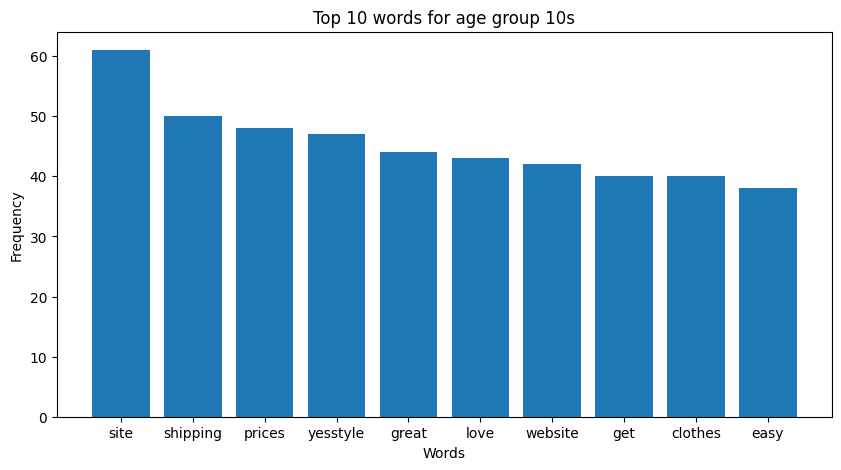

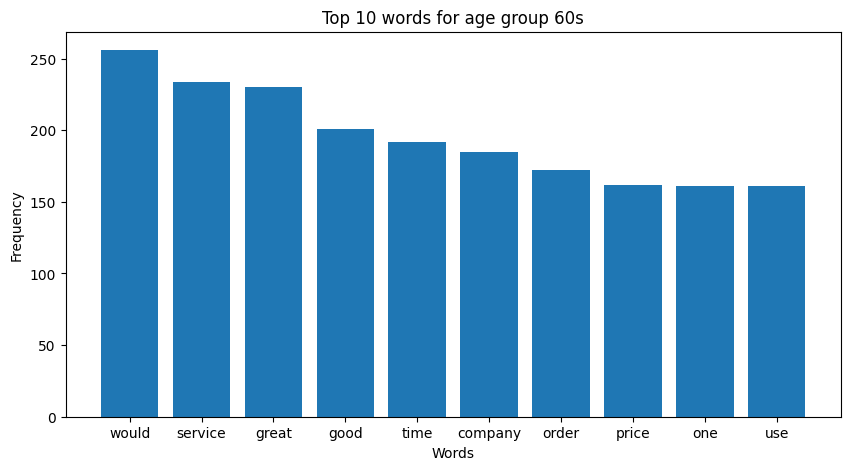

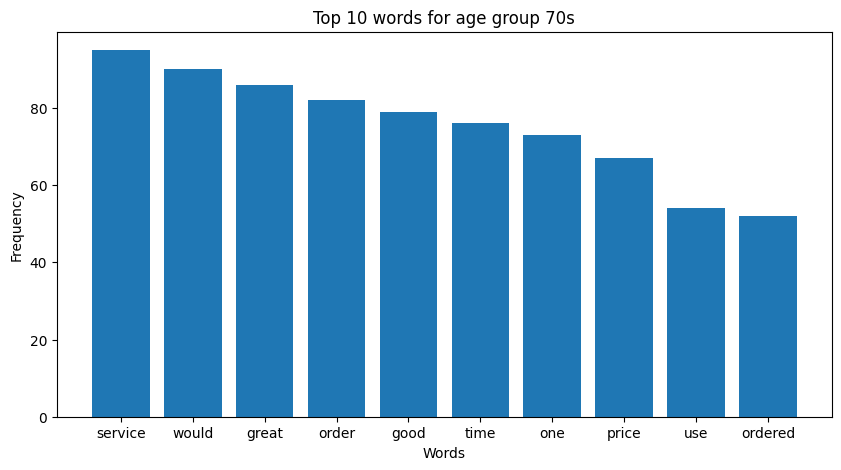

In [32]:
def word_freq(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return Counter(words)

df['word_freq'] = df['text'].apply(word_freq)

age_groups = df['age'].unique()
age_word_freq = {age: Counter() for age in age_groups}

for index, row in df.iterrows():
    age_word_freq[row['age']].update(row['word_freq'])


for age in age_groups:
    common_words = age_word_freq[age].most_common(10)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.title(f'Top 10 words for age group {age}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

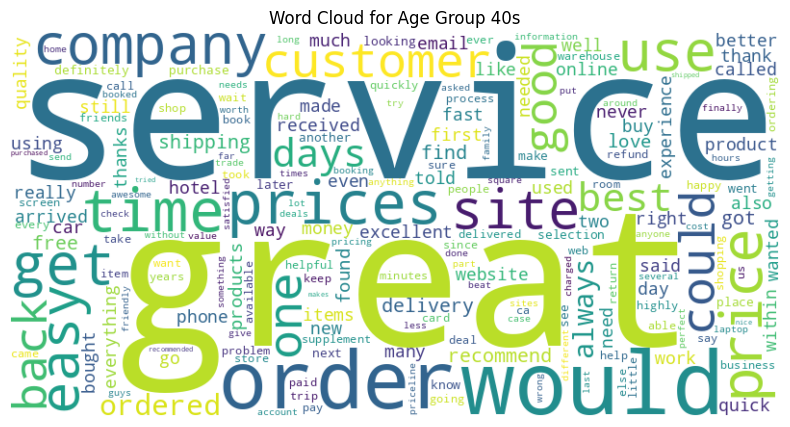

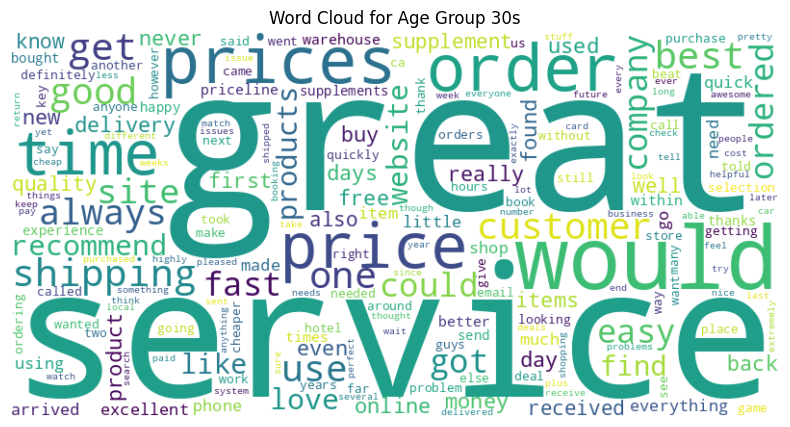

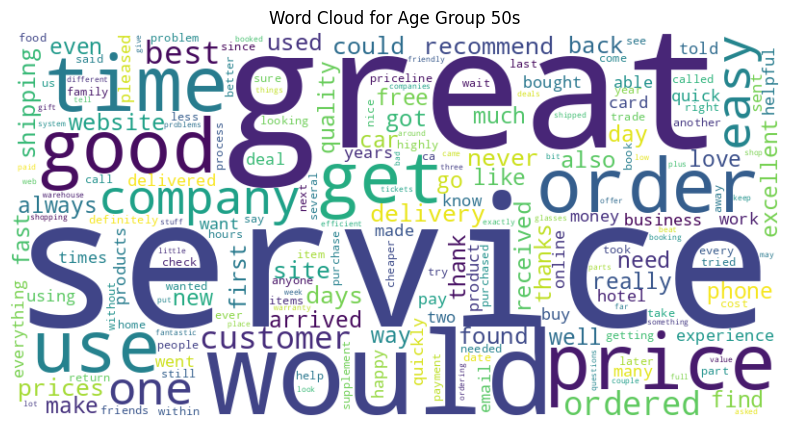

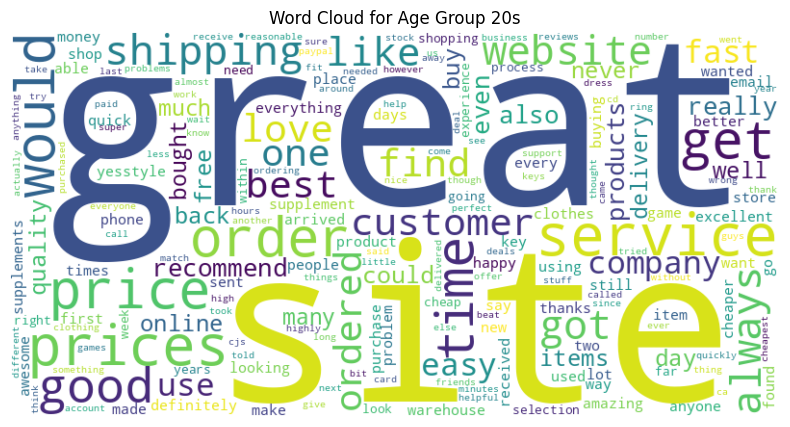

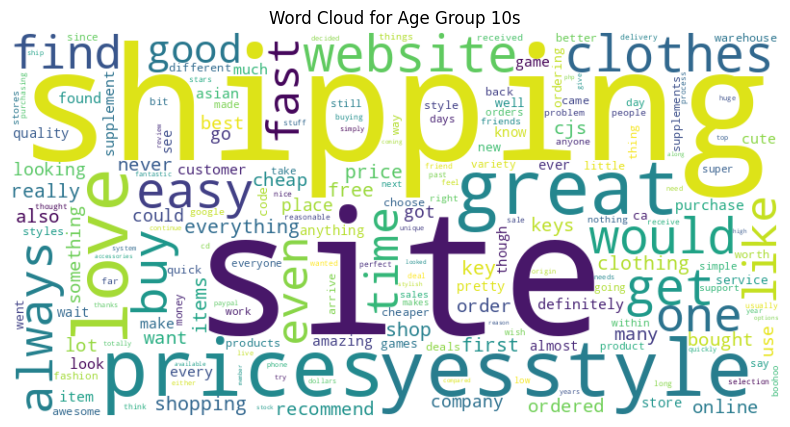

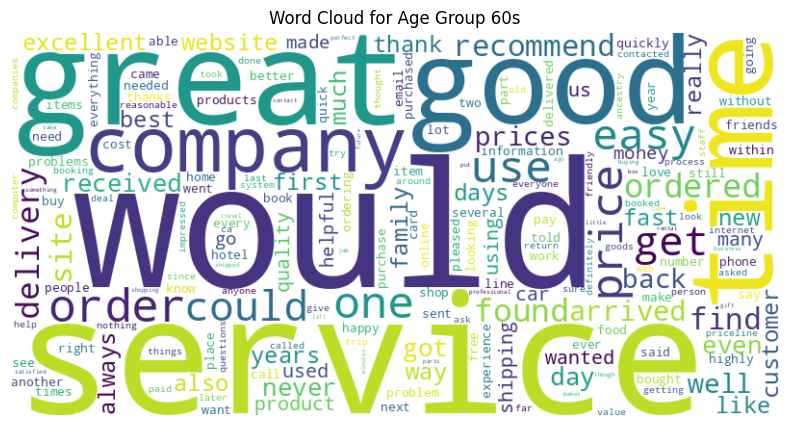

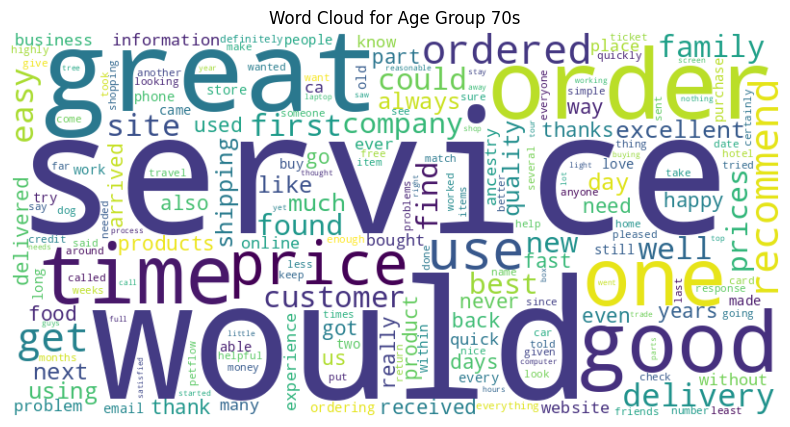

In [33]:
def word_freq(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return Counter(words)

df['word_freq'] = df['text'].apply(word_freq)

age_groups = df['age'].unique()
age_word_freq = {age: Counter() for age in age_groups}

for index, row in df.iterrows():
    age_word_freq[row['age']].update(row['word_freq'])

for age in age_groups:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(age_word_freq[age])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Age Group {age}')
    plt.show()

# Feature Importance: Analyzing which features (e.g., specific words or phrases) are most predictive of age.


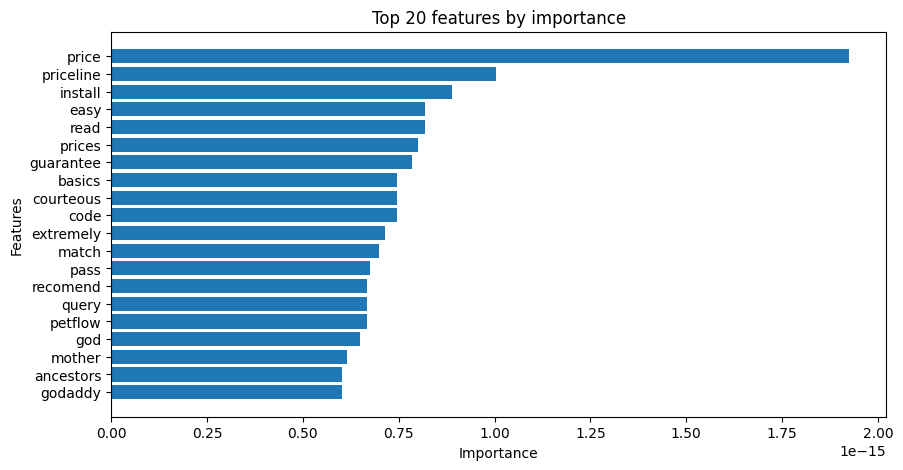

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

df['age_numeric'] = df['age'].str.replace('s', '').astype(int)
X = df['text']
y = df['age_numeric']

model = make_pipeline(CountVectorizer(stop_words='english'), LogisticRegression(max_iter=1000))
model.fit(X, y)

vectorizer = model.named_steps['countvectorizer']
logistic = model.named_steps['logisticregression']
feature_names = vectorizer.get_feature_names_out()
importance = logistic.coef_.mean(axis=0)

top_indices = importance.argsort()[-20:]
top_features = feature_names[top_indices]
top_importance = importance[top_indices]

plt.figure(figsize=(10, 5))
plt.barh(top_features, top_importance)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 features by importance')
plt.show()



# Text Characteristics by Age: Identifying common themes or topics in text data associated with different age groups.



In [35]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X_tfidf)

topic_assignments = lda.transform(X_tfidf).argmax(axis=1)
df['topic'] = topic_assignments

In [39]:
df['topic']

0       3
1       2
2       2
3       3
4       4
       ..
4991    3
4992    2
4993    3
4994    3
4995    3
Name: topic, Length: 4996, dtype: int64

In [46]:
num_words = 10
topic_names = []
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-num_words:]
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_indices]
    topic_name = ", ".join(top_words[:3])
    topic_names.append(f'Topic {topic_idx}: {topic_name}')

In [48]:
topic_names_dict = {}
for each_topic in topic_names:
    each_topic = each_topic.split(":")
    topic_names_dict[each_topic[0]] = each_topic[1]
    
topic_names_dict

{'Topic 0': ' bookers, responsive, movies',
 'Topic 1': ' necklace, flowers, love',
 'Topic 2': ' minutes, avast, code',
 'Topic 3': ' best, order, shipping',
 'Topic 4': ' yesstyle, site, days'}

In [55]:
df.head()

,age,text,text_sent_len,text_word_len,text_sentiment,word_freq,age_numeric,topic
0,40s,Not the best overall service.,1,6,negative,"{'best': 1, 'overall': 1, 'service': 1}",40,3
1,40s,Since it is the #1 social network however with...,1,53,positive,"{'since': 1, 'social': 1, 'network': 1, 'howev...",40,2
2,40s,"Not only that you can find anything, but its r...",1,16,positive,"{'find': 1, 'anything': 1, 'resources': 1, 'ap...",40,2
3,40s,I'm always satisfied with their level of servi...,2,42,positive,"{'always': 1, 'satisfied': 1, 'level': 1, 'ser...",40,3
4,30s,"On time, nice chap and worked like a pro - Ver...",1,17,positive,"{'time': 1, 'nice': 1, 'chap': 1, 'worked': 1,...",30,4


In [56]:
def get_topic_name(topic_num):
    topic_num = "Topic "+str(topic_num)
    return topic_names_dict[topic_num]

In [58]:
df["topic_name"] = df["topic"].apply(get_topic_name)

In [59]:
df.head()

,age,text,text_sent_len,text_word_len,text_sentiment,word_freq,age_numeric,topic,topic_name
0,40s,Not the best overall service.,1,6,negative,"{'best': 1, 'overall': 1, 'service': 1}",40,3,"best, order, shipping"
1,40s,Since it is the #1 social network however with...,1,53,positive,"{'since': 1, 'social': 1, 'network': 1, 'howev...",40,2,"minutes, avast, code"
2,40s,"Not only that you can find anything, but its r...",1,16,positive,"{'find': 1, 'anything': 1, 'resources': 1, 'ap...",40,2,"minutes, avast, code"
3,40s,I'm always satisfied with their level of servi...,2,42,positive,"{'always': 1, 'satisfied': 1, 'level': 1, 'ser...",40,3,"best, order, shipping"
4,30s,"On time, nice chap and worked like a pro - Ver...",1,17,positive,"{'time': 1, 'nice': 1, 'chap': 1, 'worked': 1,...",30,4,"yesstyle, site, days"


In [61]:
age_groups = df["age"].unique()
topic_distributions = {age: df[df['age'] == age]['topic_name'].value_counts().sort_index() for age in age_groups}


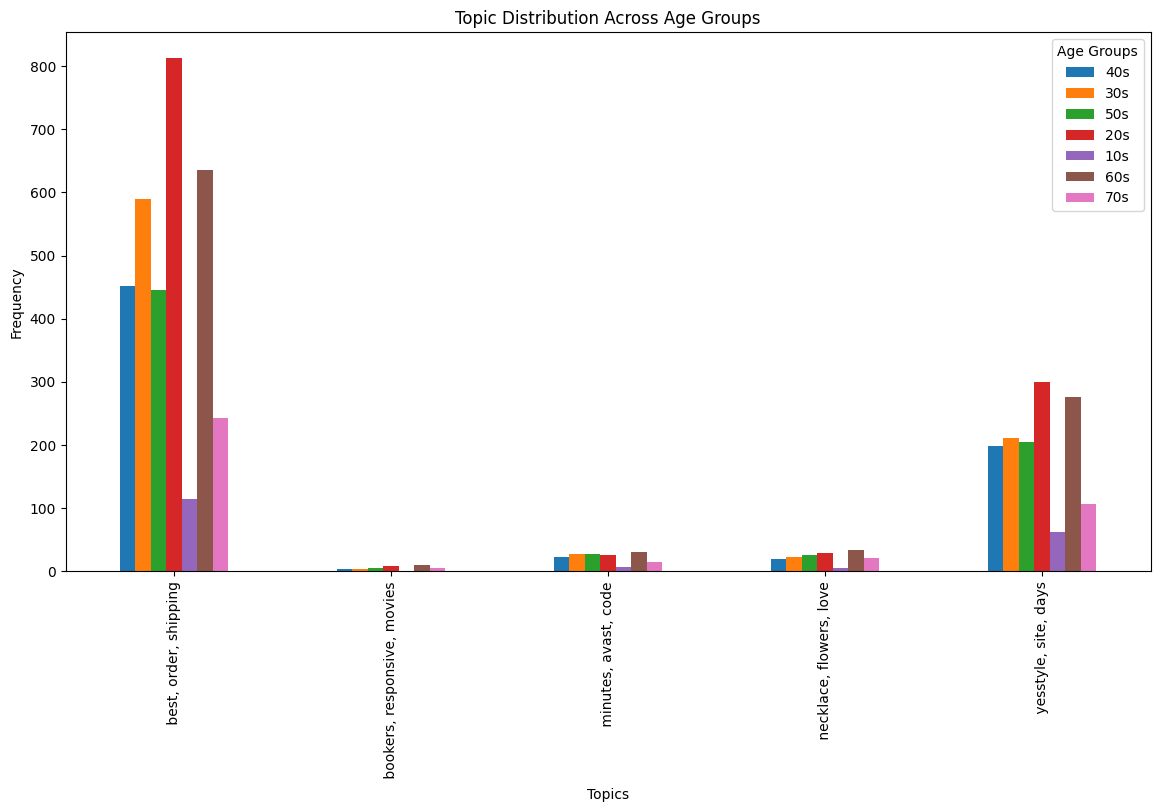

In [62]:
topic_dist_df = pd.DataFrame(topic_distributions).fillna(0).astype(int)

topic_dist_df.plot(kind='bar', figsize=(14, 7))
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Topic Distribution Across Age Groups')
plt.legend(title='Age Groups')
plt.show()